In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
import seaborn as sns
from mesa.datacollection import DataCollector
import pandas as pd
import random

In [2]:
#data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
#the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023, where afterwards it only takes the 10 year, 
# so it doesn't take the year 2023 wit it

df = pd.read_csv('data_interest_rate.csv')
df2 = df.drop([df.index[120]])
df3 = df2["interest_rate"]
INTEREST_RATE = list(df3)
print(INTEREST_RATE[:5])

#data from ...
df_infl = pd.read_csv("inflationp2.csv")
INFLATION = [inflation / 12 for inflation in df_infl["inflation"] for _ in range(12)]
print(INFLATION[:5])

#global variables
HOUSE_SIZES = ["XS", "S", "M", "L", "XL"]

# controle data / real situation
df_controle = pd.read_csv("AVG_house_price.csv")
df_controle.rename(columns={'observation_date': 'date',
                             'ASPUS': 'Mean Sales Price'}, inplace=True)
CONTROLE = df_controle["Mean Sales Price"]
display(CONTROLE.head())

[0.08440142, 0.17210018, 0.05034072, -0.02421188, -0.01939123]
[0.122069388, 0.122069388, 0.122069388, 0.122069388, 0.122069388]


0    307400
1    320400
2    324400
3    334400
4    331400
Name: Mean Sales Price, dtype: int64

In [3]:
#Location data
#probabilities are based on data from https://worldpopulationreview.com/states

west = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
west_prob = [11.57 / 100, 1.26 / 100, 2.33 / 100, 0.96 / 100, 0.59 / 100, 1.03 / 100, 1.76 / 100, 0.17 / 100, 0.34 / 100]
midwest = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
midwest_prob = [0.23 / 100, 0.28 / 100, 0.59 / 100, 0.88 / 100, 1.72 / 100, 0.96 / 100, 1.85 / 100, 1.77 / 100, 3.73 / 100, 2.05 / 100, 2.99 / 100, 3.52 / 100]
southwest = ["AZ", "NM", "TX", "OK"]
southwest_prob = [2.23 / 100, 0.63 / 100, 9.22 / 100, 1.22 / 100]
southeast = ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"]
southeast_prob = [0.92 / 100, 1.36 / 100, 0.88 / 100, 2.14 / 100, 1.53 / 100, 1.35 / 100, 3.32 / 100, 0.53 / 100, 2.61 / 100, 3.27 / 100, 1.63 / 100, 6.83 / 100, 1.83 / 100, 0.31 / 100]
northeast = ["CT", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
northeast_prob = [1.08 / 100, 0.42 / 100, 2.09 / 100, 0.42 / 100, 2.78 / 100, 5.8 / 100, 3.86 / 100, 0.33 / 100, 0.19 / 100]
hawai_group = ["HI"]
hawai_group_prob = [0.42 / 100]
alaska_group =["AK"]
alaska_group_prob = [0.22 / 100]

#Global variables for location
USA_LOCATIONS = [southeast, west, midwest, southwest, northeast, hawai_group, alaska_group]
USA_LOCATION_GENERATE = southeast + west + midwest + southwest + northeast + hawai_group + alaska_group #locations for generating
USA_LOCATIONS_PROB = southeast_prob + west_prob + midwest_prob + southwest_prob + northeast_prob + hawai_group_prob + alaska_group_prob

In [4]:
#costs per square foot for each state
# based on information from https://www.home-cost.com/cost-per-sf-by-state/
AVERAGE_COST_PER_SF = {
    'AL': 115, 'AK': 225, 'AZ': 155,
    'AR': 120, 'CA': 300, 'CO': 200,
    'CT': 215, 'DE': 145, 'FL': 155,
    'GA': 140, 'HI': 450, 'ID': 150,
    'IL': 160, 'IN': 130, 'IA': 130,
    'KS': 130, 'KY': 120, 'LA': 120,
    'ME': 200, 'MD': 160, 'MA': 275,
    'MI': 140, 'MN': 200, 'MS': 115,
    'MO': 130, 'MT': 200, 'NE': 130,
    'NV': 190, 'NH': 200, 'NJ': 240,
    'NM': 140, 'NY': 275, 'NC': 140,
    'ND': 130, 'OH': 130, 'OK': 115,
    'OR': 200, 'PA': 160, 'RI': 215,
    'SC': 140, 'SD': 130, 'TN': 155,
    'TX': 150, 'UT': 155, 'VT': 200,
    'VA': 160, 'WA': 200, 'WV': 120,
    'WI': 160, 'WY': 200
}

## Help function

In [5]:
def location_pref(location_person, location_building):
    """Gives 1 back if location is the same, 2 if location is nearby and 3 if none of the two before"""
    temp_var = None
    if location_person == location_building:
        return 1
    else:
        for i in range(len(USA_LOCATIONS)):
            if location_person in USA_LOCATIONS[i]:
                temp_var = i
                break
    if temp_var != None and location_building in USA_LOCATIONS[temp_var]:
        return 2
    return 3

def set_age():
    """Randomly choses a age. This function is used for creating buyers"""
    age_group = np.random.choice(['18-24','25-64','65+'], p=[0.13, 0.69, 0.18])
    if age_group == '18-24':
        return np.random.randint(18, 24)
    elif age_group == '25-64':
        return np.random.randint(25, 64)
    else:
        return np.random.randint(65, 80)

## Model and Agents

In [6]:
class BuyerAgent(Agent):
    def __init__(self, model, mortage_from_calc, age):
        super().__init__(model)
        
        #Us avarage of percentage to mortage in US is around the 30 % according to:
        # https://usafacts.org/data-projects/housing-costs
        mean_percentage = 0.30
        std_percentage = 0.05
        willing_to_pay = np.clip(np.random.normal(mean_percentage, std_percentage), 0.1, 0.6)

        age_group = random.choices(['18-24','25-64','65+'], weights=[0.13, 0.69, 0.18], k=1)[0]
        edu_group = random.choices(['hs', 'ass', 'bac'], weights=[45, 17, 38], k=1)[0]
        if age_group == '18-24':
                age = random.randint(18, 24)
        elif age_group == '25-64':
                age = random.randint(25, 64)
        else:
                age = random.randint(65, 80)

        # pension calculation found at https://equable.org/pension-basics-how-pension-benefits-are-calculated/
        # average age for a degree found at https://learn.org/articles/normal_age_finish_college.html
        if age_group != '65+':
                if edu_group == 'hs':
                    mean_salary = 42100 * model.inflation / 12
                elif edu_group == 'ass':
                    mean_salary = 50600 * model.inflation / 12
                else:
                    mean_salary = 68500 * model.inflation / 12
        else:
                if edu_group == 'hs':
                    mean_salary = (random.randint(59, 65) - random.randint(17, 18)) * 0.02 * 42100 / 12 * model.inflation
                elif edu_group == 'ass':
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 50600 / 12 * model.inflation
                else:
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 68500 / 12 * model.inflation
        std_dev_salary = 1000

        #np.clip only gives numbers between the two given numbers, in this case 1000 and 20000
        salary = np.clip(np.random.normal(mean_salary, std_dev_salary), 1000.0, 20000.0)

        
        # M = P * (r * (1 + r)^360) / ((1 + r)^360 - 1) based on https://www.bankrate.com/mortgages/mortgage-calculator/#calculate-mortgage-payment
        # P is principal loan amount, M is monthly payment (here max monthly payment) and r = interest rate monthly
        # Converted = P = M / (r * (1 + r)^360) / ((1 + r)^360 - 1)
        # This is already calculated before it comes here, with the input of the variable mortage_from_calc.
        M = salary * willing_to_pay
        self.budget = (M * mortage_from_calc)

        assert self.budget > 0, 'Budget must be a positive number'

        self.preference_location = np.random.choice(USA_LOCATION_GENERATE)

        #variables to keep track of information
        self.months = 0
        self.age = age
        self.death_rate = self.calc_death(age)
        prob_not_bought_before = min(1, self.age / 40)
        self.bought_before = np.random.choice([True, False], p = [prob_not_bought_before, 1 - prob_not_bought_before])

    def calc_death(self, age):
        """Sets the death rate for different ages."""
        # death rates by age data found at: https://www.cdc.gov/nchs/products/databriefs/db492.htm
        assert age >= 18, 'Invalid age'

        if 18 < age < 24:
            return 80/100000
        elif 24 <= age < 34:
            return 163.4/100000
        elif 34 <= age < 44:
            return 255.4/100000
        elif 44 <= age < 54:
            return 453.3/100000
        elif 54 <= age < 64:
            return 992.1/100000
        elif 64 <= age < 74:
            return 1978.7/100000
        elif 74 <= age < 84:
            return 4708.2/100000
        else:
            return 14389.6/100000

    def location_check(self, location_building):
        """Looks if the location of the house is according to the rpeference of the buyer.
        This is if the location is the same state or if the buyer is a first time buyer, then it 
        can slo be in a state in the same area (e.g. midwest)."""
        check_var = location_pref(self.preference_location, location_building)
        if self.bought_before == False:
            if check_var in [1, 2]:
                return True
            else:
                return False
        else:
            if check_var == 1:
                return True
            else:
                return False
    
    def buy_house(self, model):
        """Function that buys a house and the thing involved."""

        chosen_seller = None
        sellers = model.Seller_Agents
        affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
        if not affordable_sellers:
            return
        
        # A house is for sure sold if the location and preference and size and preference are the same. If the budget doesn't differ more than 100000
        # The other option is that someone buys for the first time and is in the same area (different lists inside mortage_from_calc)
        buy_budget = self.budget
        perfect_combos = [seller for seller in affordable_sellers if self.location_check(seller.location) and abs(seller.cost - buy_budget) <= 10000]
        if perfect_combos:
            chosen_seller = np.random.choice(perfect_combos)   
        else:
            #Very small change someone buys a house that is not really the preference
            if affordable_sellers and np.random.rand() > 0.01:
                chosen_seller = np.random.choice(affordable_sellers)
                
        if chosen_seller:
            model.sales_this_month.append(chosen_seller.cost)
            model.existing_houses.append(chosen_seller)
            chosen_seller.months = 0
            model.Seller_Agents.remove(chosen_seller)
            model.Buyer_Agents.remove(self)
            if self in model.Buyer_Agents:
                print("Something went wrong") 

class SellerAgent(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.location = np.random.choice(USA_LOCATION_GENERATE)
        self.size = np.clip(np.random.normal(2000, 400), 500, 10000)
        self.cost = AVERAGE_COST_PER_SF[self.location] * self.size * model.inflation * (1 + model.historice_growth_month) ** model.month
        self.orig_cost = self.cost
        self.location = np.random.choice(USA_LOCATION_GENERATE)
        self.months = 0

    def change_cost(self, model, demand_supply_ratio, growth_multiplier, base_growth):
        if demand_supply_ratio > 1:
            self.cost *= (1 + base_growth * growth_multiplier)
        
        # Adjust downward if unsold for too long
        # Can't go below 0.6, because people don't go infinite low if their house doesn;t sell.
        if self.months > 1 and self.cost > self.orig_cost * 0.6:
            self.cost *= 0.95

        assert self.cost > 0, 'Cost must be a positive number'

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, interest_rate, seed=None):
        super().__init__(seed=seed)
        self.interest_rate = interest_rate
        self.historice_growth_month = 0.035 / 12
        self.inflation = 1
        self.num_sold = 0
        self.month = 1
        self.Buyer_Agents = []
        self.existing_houses = [SellerAgent(self) for _ in range(number_of_sellers)]
        self.Seller_Agents = []

        # Data collection lists
        self.total_sales = []
        self.Mean_Sale_Prices = []
        self.Unsold_houses = []
        self.Number_of_buyers = []
        self.Number_of_houses_sold = []
        self.sales_this_month = []

    def step(self, interest_rate_step, inflation, p_new_buyers, base_growth):
        """Steps one month further in the world."""
        self.sales_this_month = []
        self.interest_rate = interest_rate_step
        self.inflation *= (1 + inflation / 100)
        self.use_inflation(inflation)
        self.add_agents_per_step(p_new_buyers)
        self.bought_to_sell()
        
        np.random.shuffle(self.Buyer_Agents)
        for buyer in self.Buyer_Agents:
            buyer.buy_house(self)

        demand_supply_ratio = len(self.Buyer_Agents) / max(1, len(self.Seller_Agents))
        growth_multiplier = min(1, demand_supply_ratio)
        np.random.shuffle(self.Seller_Agents)
        for seller in self.Seller_Agents:
            seller.change_cost(self, demand_supply_ratio, growth_multiplier, base_growth)
        self.collect_data()
        self.month += 1
        self.total_sales = self.total_sales + self.sales_this_month

    def collect_data(self):
        """Collects the data that we want to collect"""
        self.Mean_Sale_Prices.append(self.compute_mean_house_price())
        if self.Mean_Sale_Prices[-1] == 0 and len(self.Mean_Sale_Prices) > 1:
            self.Mean_Sale_Prices[-1] = self.Mean_Sale_Prices[-2]
        self.Unsold_houses.append(self.compute_unsold_inventory())
        self.Number_of_buyers.append(self.compute_num_house_buyers())
        self.Number_of_houses_sold.append(self.compute_num_sold())
    
    def return_total_sales(self):
        return self.total_sales
    
    def compute_mean_house_price(self):
        if len(self.sales_this_month) > 0:
            return np.mean(self.sales_this_month)  
        else:
            return 0

    def compute_unsold_inventory(self):
        return len(self.Seller_Agents)

    def compute_num_house_buyers(self):
        return len(self.Buyer_Agents)
    
    def compute_num_sold(self):
        return len(self.sales_this_month)
    
    def use_inflation(self, inp_inflation):
        """Upps the budgets and costs of the houses and buyers. Does this absed on the inlfation and economic growth
        In this function the age, death rate and number of month existing also change, because this has to happend and 
        implementing it in this function is faster than doeing it else where, because it only has to loop once through 
        everything now."""
        inflation_factor = (1 + inp_inflation / 100) * (1 + self.historice_growth_month)
        buyer_budget = np.array([buyer.budget for buyer in self.Buyer_Agents])
        buyer_budget *= inflation_factor
        for buyer, budget in zip(self.Buyer_Agents, buyer_budget):
            buyer.budget = budget
            buyer.months += 1

            buyer.age += 1/12
            buyer.death_rate = buyer.calc_death(buyer.age)
            
            if random.random() < buyer.death_rate:
                self.Buyer_Agents.remove(buyer)

        seller_costs = np.array([seller.cost for seller in self.Seller_Agents])
        seller_costs *= inflation_factor
        for seller, cost in zip(self.Seller_Agents, seller_costs):
            seller.cost = cost
            seller.months += 1

        existing_costs = np.array([house.cost for house in self.existing_houses])
        existing_costs *= inflation_factor
        for house, cost in zip(self.existing_houses, existing_costs):
            house.cost = cost
            

    def add_agents_per_step(self, p_new_buyers):
        """This function adds new buyers and sellers based on how many houses there are currently"""
        num_extra_buyers = int(p_new_buyers * len(self.existing_houses) / 12 + 0.5) #assumption
        monthly_interest_rate = self.interest_rate / 100 / 12

        #assumption paying mortage in 30 years. 30 * 12 = 360 payments
        payments = 360

        mortage_calc = ((1 + monthly_interest_rate)**payments - 1) / (monthly_interest_rate * (1 + monthly_interest_rate)**payments)
        new_Buyer_Agents = [BuyerAgent(self, mortage_calc, set_age()) for _ in range(num_extra_buyers)]
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents
        
        num_extra_sellers = int(0.0114 * len(self.existing_houses) / 12 + 0.5)
        #during the corona period the supply of new houses went down.
        if self.month >= 98 and self.month <= 121:
            num_extra_sellers = int(num_extra_sellers * 0.6)
        new_Seller_Agents =  [SellerAgent(self) for _ in range(num_extra_sellers)]
        self.Seller_Agents = self.Seller_Agents + new_Seller_Agents

    def bought_to_sell(self):
        """Function makes people that once bought a house a seller

        https://www.census.gov/construction/nrc/pdf/newresconst.pdf and https://ceramicworldweb.com/en/economics-and-markets/another-difficult-year-us-housing-market#:~:text=In%202023%20the%20U.S.%20residential,also%20for%20the%20year%202024. 
        -> aproxamaly 1.4 mil new houses
        122.4 mil households in 2013
        so approx 4 mil houses are resold each year (based on house_sold_2014-2023 png)
        4 / 122.4 =  3,3 % resold
        1.4 / 122.4 = 1.14 % new built each year of original houses there are
        """
        procent_of_people_selling = 0.033 / 12
        num_new_seller = int(procent_of_people_selling * len(self.existing_houses) + 0.5)
        num_new_buyers = num_new_seller

        #during the corona period the supply of new houses went down.
        if self.month >= 98 and self.month <= 121:
            num_new_seller = int(num_new_seller * 0.6)

        for _ in range(num_new_seller):
            new_seller = np.random.choice(self.existing_houses)
            self.Seller_Agents.append(new_seller)
            self.existing_houses.remove(new_seller)
        
        interest_rate_monthly = self.interest_rate / 100 / 12
        payments = 360
        mortage_calc = ((1 + interest_rate_monthly)**payments - 1) / (interest_rate_monthly * (1 + interest_rate_monthly)**payments)
        new_Buyer_Agents = [BuyerAgent(self, mortage_calc, set_age()) for _ in range(num_new_buyers)]
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents

Simulate model with real data input

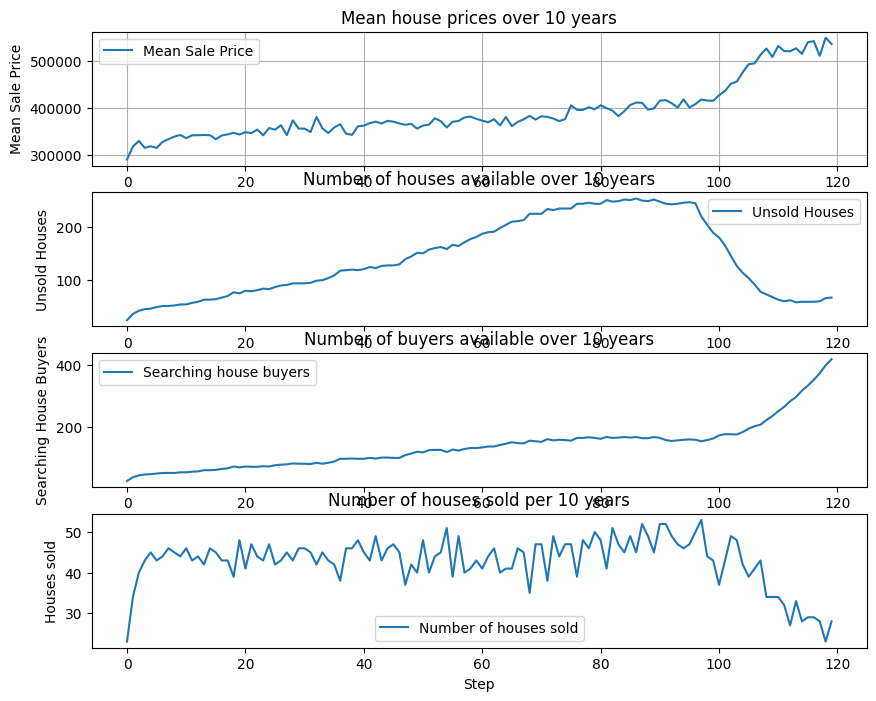

In [10]:
result_list = []
for _ in range(5):
    model = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE[0])
    for i in range(10*12):
        model.step(interest_rate_step = INTEREST_RATE[i], inflation = INFLATION[i], p_new_buyers = 0.0116, base_growth = 0.011)

    results = [model.Mean_Sale_Prices, model.Unsold_houses, model.Number_of_buyers, model.Number_of_houses_sold]
    result_list.append(model.Mean_Sale_Prices)

mean_prices_list = np.mean(result_list, axis = 0)
plt.figure(figsize = (10, 8))

plt.subplot(411)
plt.plot(mean_prices_list, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.legend()

plt.subplot(412)
plt.title("Number of houses available over 10 years")
plt.plot(results[1], label = 'Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(413)
plt.title("Number of buyers available over 10 years")
plt.plot(results[2], label = 'Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching House Buyers')
plt.legend()

plt.subplot(414)
plt.title("Number of houses sold per 10 years")
plt.plot(results[3], label = 'Number of houses sold')
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.legend()

plt.show()

## Verifiation

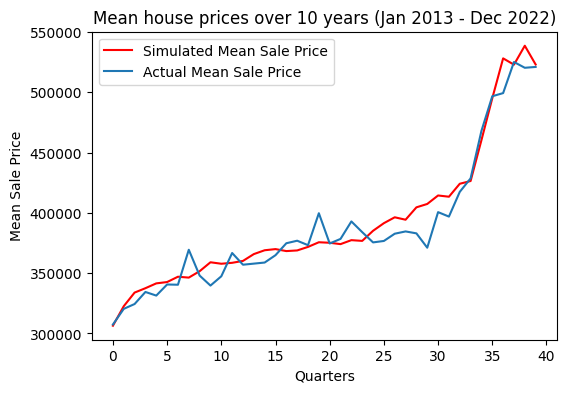

In [158]:
plt.figure(figsize = (6, 4))

controle = pd.read_csv("AVG_house_price.csv")
controle2 = list(controle["ASPUS"][:40])

def results_to_per_quarter(results):
    ds_results = []
    sum_var = 0
    for i in range(len(results)):
        sum_var += results[i]
        if (i + 1) % 3 == 0:
            ds_results.append(sum_var / 3)
            sum_var = 0
    return ds_results

result_per_qt = results_to_per_quarter(list(mean_prices_list))
plt.plot(result_per_qt, label = 'Simulated Mean Sale Price', color = "red")
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2022)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

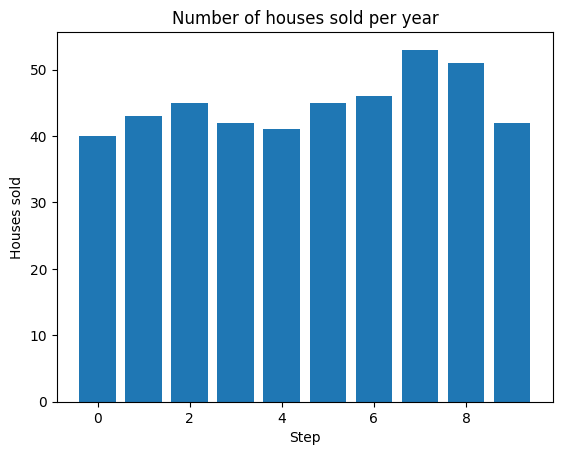

In [177]:
# Used to see wether there are any weird results
house_sold_per_year = [0 for _ in range(10)]
for i in range(10):
    for j in range(12):
        house_sold_per_year[i] += results[3][(i + 1) * j] 

plt.bar([i for i in range(10)], house_sold_per_year)
plt.title("Number of houses sold per year")
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.show()
plt.close()

## Verifation

In [89]:
# This code was first run with: input_opt_new_buyers = [0.0114, 0.0117 ,0.0120, 0.0123, 0.0126] and input_options_base_growth = [0.01, 0.02, 0.03, 0.04, 0.05]
# The result was: [0.0114, 0.01]
# Then it was run with: input_opt_new_buyers = [0.0114, 0.0115 ,0.0116, 0.0117, 0.0118] and input_options_base_growth = [0.005, 0.008, 0.012, 0.016, 0.02]
# The result was: [0.0116, 0.012]
# Then input_opt_new_buyers was set at 0.0116 and input_options_base_growth = [0.1, 0.11, 0.12, 0.13, 0.14]. Result was 0.11

def run_model(p_new_buyers, base_growth):
    result_list = []
    for _ in range(5):
        model = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE[0])
        for i in range(10*12):
            model.step(interest_rate_step = INTEREST_RATE[i], inflation = INFLATION[i], p_new_buyers = p_new_buyers, base_growth = base_growth)

        result_list.append(model.Mean_Sale_Prices)
    return np.mean(result_list, axis = 0)

def diff_calc(results_sim: list, control_data: list):
    """This function calculates the absolute difference between two list"""
    if len(results_sim) != len(control_data):
        print("Wrong input")
        return
    sum_dif = 0
    for i in range(len(results_sim)):
        sum_dif += abs(results_sim[i] - control_data[i])
    return sum_dif

lowest_diff = -1
input_opt_new_buyers = [0.0114, 0.0115 ,0.0116, 0.0117, 0.0118]
input_options_base_growth = [0.1, 0.11, 0.12, 0.13, 0.14]
best_result = [-1, -1]
best_inp_new_buy = -1
for i in range(5):
    temp_input_base_growth = 0.25
    result_l = run_model(input_opt_new_buyers[i], temp_input_base_growth)
    diff = diff_calc(list(results_to_per_quarter(result_l)), controle2)
    print(diff)
    if lowest_diff == -1 or diff < lowest_diff:
        lowest_diff = diff
        best_inp_new_buy = input_opt_new_buyers[i]
best_result[0] = best_inp_new_buy
best_inp_base_growth = -1
lowest_diff = -1
for j in range(5):
    result_l = run_model(0.0116, input_options_base_growth[j])
    diff = diff_calc(list(results_to_per_quarter(result_l)), controle2)
    print(diff)
    if lowest_diff == -1 or diff < lowest_diff:
        lowest_diff = diff
        best_inp_base_growth = input_options_base_growth[j]
print(best_inp_base_growth)

## Input Lists for simulation

In [8]:
INTEREST_RATE_1P_CONST = [1 for _ in range(120)]
INTEREST_RATE_2P_CONST = [2 for _ in range(120)]
INTEREST_RATE_3P_CONST = [3 for _ in range(120)]
INTEREST_RATE_4P_CONST = [4 for _ in range(120)]
INTEREST_RATE_5P_CONST = [5 for _ in range(120)]

## Simulations of the different interest rates

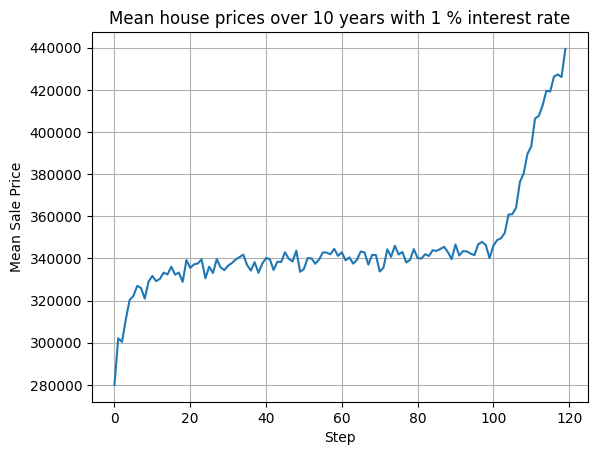

In [135]:
results2 = []

for _ in range(20):
    model2 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_1P_CONST[0])
    for i in range(10*12):
        model2.step(interest_rate_step = INTEREST_RATE_1P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)
        results2.append(model2.Mean_Sale_Prices)

results2_mean = np.mean(results2, axis = 0)

plt.plot(results2_mean, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

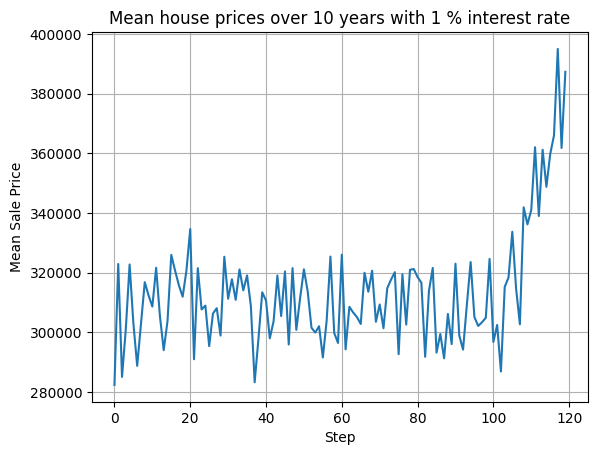

In [103]:
results3 = []

for _ in range(10):
    model3 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_2P_CONST[0])
    for i in range(10*12):
        model3.step(interest_rate_step = INTEREST_RATE_2P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)
        results3.append(model3.Mean_Sale_Prices)

results3_mean = np.mean(results3, axis = 0)

plt.plot(results3_mean, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

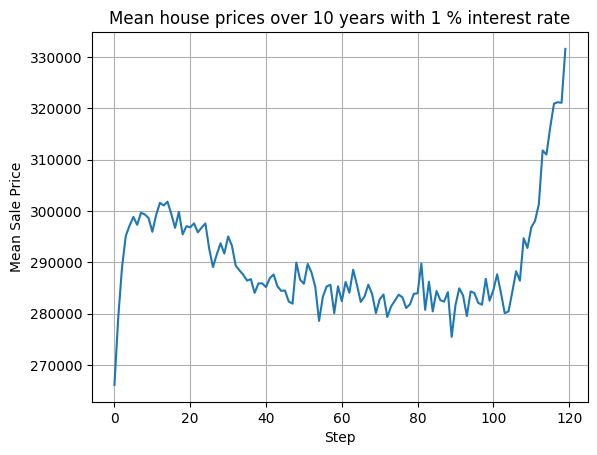

In [136]:
results4 = []

for _ in range(20):
    model4 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_3P_CONST[0])
    for i in range(10*12):
        model4.step(interest_rate_step = INTEREST_RATE_3P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)
        results4.append(model4.Mean_Sale_Prices)

results4_mean = np.mean(results4, axis = 0)

plt.plot(results4_mean, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

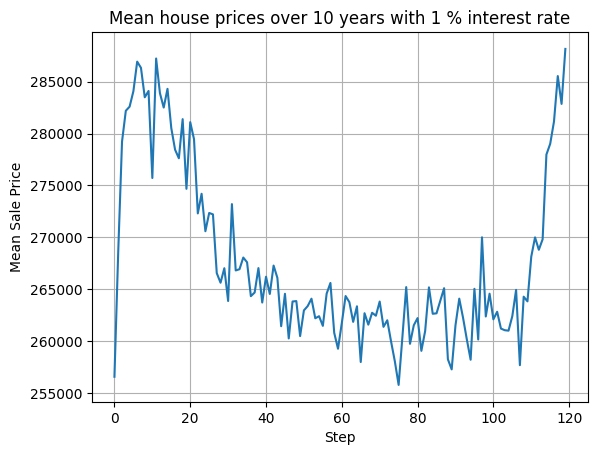

In [137]:
results5 = []

for _ in range(20):
    model5 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_4P_CONST[0])
    for i in range(10*12):
        model5.step(interest_rate_step = INTEREST_RATE_4P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)
        results5.append(model5.Mean_Sale_Prices)

results5_mean = np.mean(results5, axis = 0)

plt.plot(results5_mean, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

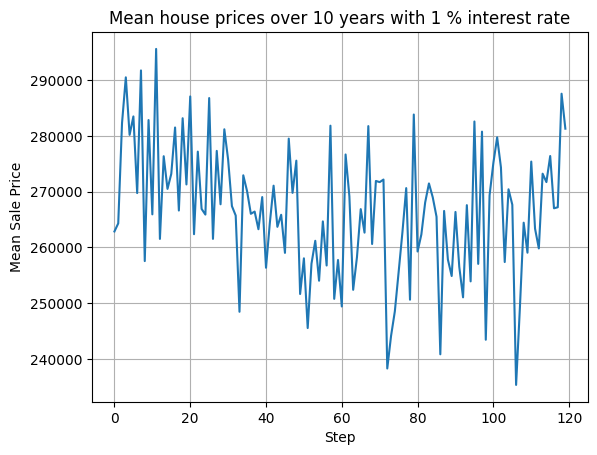

In [138]:
results6 = []

for _ in range(20):
    model6 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_5P_CONST[0])
    for i in range(10*12):
        model6.step(interest_rate_step = INTEREST_RATE_5P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)
        results6.append(model5.Mean_Sale_Prices)

results6_mean = np.mean(results6, axis = 0)

plt.plot(results6_mean, label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

## Comparison of the different results

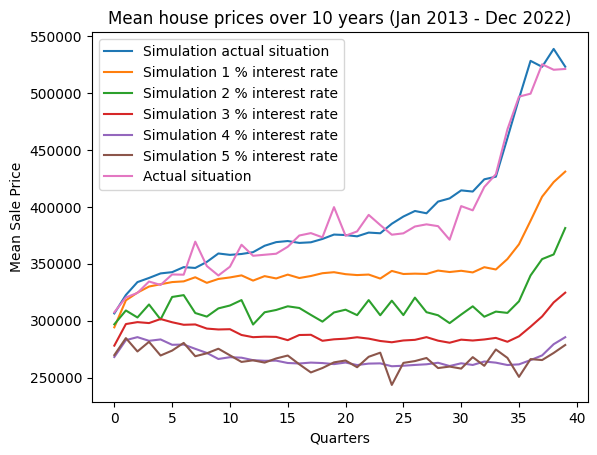

In [139]:
# change results per onth to results per querter to compare it with original data
results_per_qt1 = results_to_per_quarter(mean_prices_list)
results_per_qt2 = results_to_per_quarter(results2_mean)
results_per_qt3 = results_to_per_quarter(results3_mean)
results_per_qt4 = results_to_per_quarter(results4_mean)
results_per_qt5 = results_to_per_quarter(results5_mean)
results_per_qt6 = results_to_per_quarter(results6_mean)

plt.plot(results_per_qt1, label = 'Simulation actual situation')
plt.plot(results_per_qt2, label = 'Simulation 1 % interest rate')
plt.plot(results_per_qt3, label = 'Simulation 2 % interest rate')
plt.plot(results_per_qt4, label = 'Simulation 3 % interest rate')
plt.plot(results_per_qt5, label = 'Simulation 4 % interest rate')
plt.plot(results_per_qt6, label = 'Simulation 5 % interest rate')
plt.plot(controle2, label = 'Actual situation')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2022)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

## Image of fewer simulations for more clearity

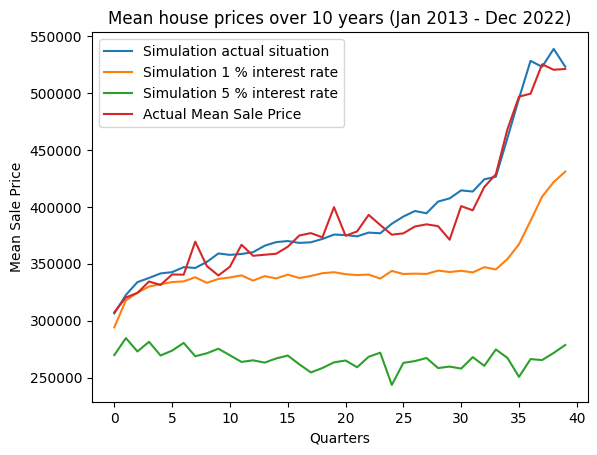

In [140]:
#more clear picture
plt.plot(results_per_qt1, label = 'Simulation actual situation')
plt.plot(results_per_qt2, label = 'Simulation 1 % interest rate')
plt.plot(results_per_qt6, label = 'Simulation 5 % interest rate')
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2022)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

In [10]:
model2_2 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_1P_CONST[0])
for i in range(10*12):
    model2_2.step(interest_rate_step = INTEREST_RATE_1P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)

model4_2 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_3P_CONST[0])
for i in range(10*12):
    model4_2.step(interest_rate_step = INTEREST_RATE_3P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)

model6_2 = House_Model(number_of_buyers = 0, number_of_sellers = 12240, seed = None, interest_rate = INTEREST_RATE_5P_CONST[0])
for i in range(10*12):
    model6_2.step(interest_rate_step = INTEREST_RATE_5P_CONST[i], inflation = INFLATION[i] / 12, p_new_buyers = 0.0116, base_growth = 0.011)

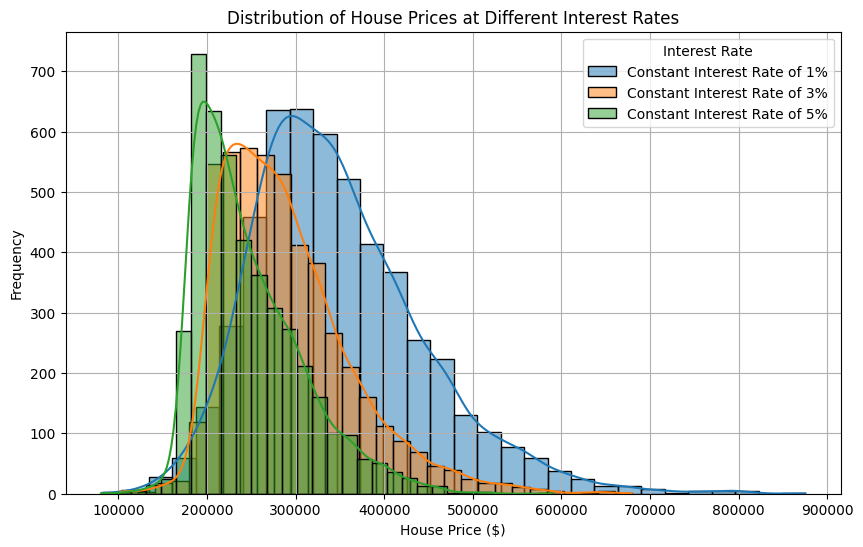

In [168]:
plt.figure(figsize=(10, 6))
results_in_list = [model2_2.total_sales, model4_2.total_sales, model6_2.total_sales]
for i in range(3):
    sns.histplot(results_in_list[i], bins=30, kde=True, label=f"Constant Interest Rate of {i * 2 + 1}%")

plt.xlabel("House Price ($)")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices at Different Interest Rates")
plt.legend(title="Interest Rate")
plt.grid(True)
plt.show()
